<a href="https://colab.research.google.com/github/YRYoung/HPC/blob/main/Assigenment/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

implement methods __init__, __add__ and matvec.

In [4]:
import numpy as np
from scipy.sparse.linalg import LinearOperator


class CSRMatrix(LinearOperator):
    # takes a COO matrix as input and will initialise the CSR matrix
    def __init__(self, arg):
        self.idx_dtype = np.int32
        self.dtype = None
        self.shape = None
        self.data = None
        self.indices = None
        self.indptr = None

        if isinstance(arg, coo_matrix):
            self.init_from_COO(arg)
        # else:
        #     self.init_from_CSR(arg)

        self.nnz = np.count_nonzero(self.data)

    def init_from_COO(self, coo):
        self.dtype = coo.dtype
        super().__init__(dtype=coo.dtype, shape=coo.shape)
        n_row, n_column = self.shape

        self.indptr = np.zeros(n_row + 1, dtype=self.idx_dtype)
        self.indices = np.empty_like(coo.col, dtype=self.idx_dtype)
        self.data = np.empty_like(coo.data, dtype=self.dtype)

        for n in range(coo.nnz):
            self.indptr[coo.row[n]] += 1

        cumsum = 0
        for i in range(n_row):
            temp = self.indptr[i]
            self.indptr[i] = cumsum
            cumsum += temp
        self.indptr[n_row] = coo.nnz

        for n in range(coo.nnz):
            row_new = coo.row[n]
            dest = self.indptr[row_new]
            self.indices[dest] = coo.col[n]
            self.data[dest] = coo.data[n]
            self.indptr[row_new] += 1

        last = 0
        for i in range(n_row + 1):
            temp = self.indptr[i]
            self.indptr[i] = last
            last = temp

    def init_from_CSR(self, arg):
        self.indptr, self.indices, self.data, self.shape = arg
        super().__init__(dtype=self.data.dtype, shape=self.shape)

    def __add__(self, other: 'CSRMatrix'):
        maxnnz = self.nnz + other.nnz
        n_row, n_col = self.shape
        # next[i] =
        # -1: no need to calculate or calculation completed
        # -2: EOF
        # other value: the next column index(indices) with a none-zero data value (not yet calculated)
        next = np.zeros(n_col, dtype=np.int32) - 1
        A_row = np.zeros(n_col)
        B_row = np.zeros(n_col)

        result = CSRMatrix((None, self.shape))
        # indptr, indices, data
        # p, j, x
        result.shape = self.shape
        result.dtype = self.dtype

        result.indptr = np.zeros_like(self.indptr, dtype=self.idx_dtype)
        result.indices = np.empty(maxnnz, dtype=self.idx_dtype)
        result.data = np.empty(maxnnz, dtype=self.dtype)

        nnz_C = 0
        # result.indptr[0] = 0
        for i in range(n_row):
            head = -2
            nnz_AB = 0

            # add a row of A to A_row
            for mat, row_mat in zip([self, other], [A_row, B_row]):
                for jj in range(mat.indptr[i], mat.indptr[i + 1]):
                    j = mat.indices[jj]
                    row_mat[j] += mat.data[jj]
                    if next[j] == -1:
                        next[j] = head
                        head = j
                        nnz_AB += 1

            # scan through columns where A or B has contributed a non-zero entry
            for jj in range(nnz_AB):
                add_result = A_row[head] + B_row[head]
                if add_result != 0:
                    result.indices[nnz_C] = head
                    result.data[nnz_C] = add_result
                    nnz_C += 1

                temp = head
                head = next[head]

                next[temp] = -1
                A_row[temp] = B_row[temp] = 0

            ## 全 0
            assert not (np.any(next + 1))
            assert not (np.any(B_row))
            assert not (np.any(A_row))
            assert head == -2

            result.indptr[i + 1] = nnz_C

        return result

    def add2(self, other: 'CSRMatrix'):
        maxnnz = self.nnz + other.nnz

        result = CSRMatrix((None, self.shape))
        result.shape = self.shape
        result.dtype = self.dtype
        result.indptr = np.zeros_like(self.indptr, dtype=self.idx_dtype)
        result.indices = np.empty(maxnnz, dtype=self.idx_dtype)
        result.data = np.empty(maxnnz, dtype=self.dtype)
        nnz_C = 0

        for i in range(self.shape[0]):

            add_result = self.row_toarray(i) + other.row_toarray(i)
            nnz = np.nonzero(add_result)[0]
            for index in nnz:
                result.indices[nnz_C] = index
                result.data[nnz_C] = add_result[index]
                nnz_C += 1

            result.indptr[i + 1] = nnz_C

        return result

    def _matvec(self, vector):
        Y = np.zeros(self.shape[0], dtype=vector.dtype)
        for i in range(self.shape[0]):
            for jj in range(self.indptr[i], self.indptr[i + 1]):
                Y[i] += self.data[jj] * vector[self.indices[jj]]
        return Y

    def row_toarray(self, row_index, row_array=None):
        if_return = False
        if row_array is None:
            row_array = np.zeros(self.shape[0])
            if_return = True

        for jj in range(self.indptr[row_index], self.indptr[row_index + 1]):
            row_array[self.indices[jj]] += self.data[jj]

        if if_return: return row_array

    def toarray(self):
        array = np.zeros(self.shape, dtype=self.dtype)
        for i in range(self.shape[0]):
            self.row_toarray(i, array[i])
        return array



Write tests to check that the __add__ and matvec methods that you have written are correct.
* These test should use appropriate assert statements.

In [43]:
from tqdm import trange
from scipy.sparse import csr_matrix


def generate_random_coo(N, nnz):
    row = np.random.randint(0, N, nnz)
    col = np.random.randint(0, N, nnz)
    data = np.random.randint(5, 22, nnz)
    return coo_matrix((data, (row, col)), shape=(N, N))


def test_add(N):
    COO_mat1 = generate_random_coo(N, np.random.randint(0, N * N))
    COO_mat2 = generate_random_coo(N, np.random.randint(0, N * N))
    my_mat1 = CSRMatrix(COO_mat1)
    my_mat2 = CSRMatrix(COO_mat2)
    my_result = my_mat2 + my_mat1
    coo_result = COO_mat1 + COO_mat2

    my_result_array_scipy = csr_matrix((my_result.data, my_result.indices, my_result.indptr),
                                       shape=my_result.shape).toarray()
    my_result_array = my_result.toarray()

    assert np.allclose(my_result_array, coo_result.toarray())
    assert np.allclose(my_result_array_scipy, my_result_array)


def test_product(N):
    COO_mat1 = generate_random_coo(N, np.random.randint(0, N * N))
    my_mat1 = CSRMatrix(COO_mat1)

    vector = np.random.random(N)

    my_result = my_mat1 * vector
    coo_result = COO_mat1 * vector
    array_result = np.matmul(COO_mat1.toarray(), vector)

    assert np.allclose(my_result, coo_result)
    assert np.allclose(array_result, my_result)


for N in trange(10, 100):
    test_add(N)
    test_product(N)

print('done')


100%|██████████| 90/90 [00:02<00:00, 44.71it/s] 

done


measure the time taken to perform a matvec product.
measure the time taken to compute a dense matrix-vector product using Numpy.
Create a plot showing the times of matvec and Numpy for a range of matrix sizes

100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


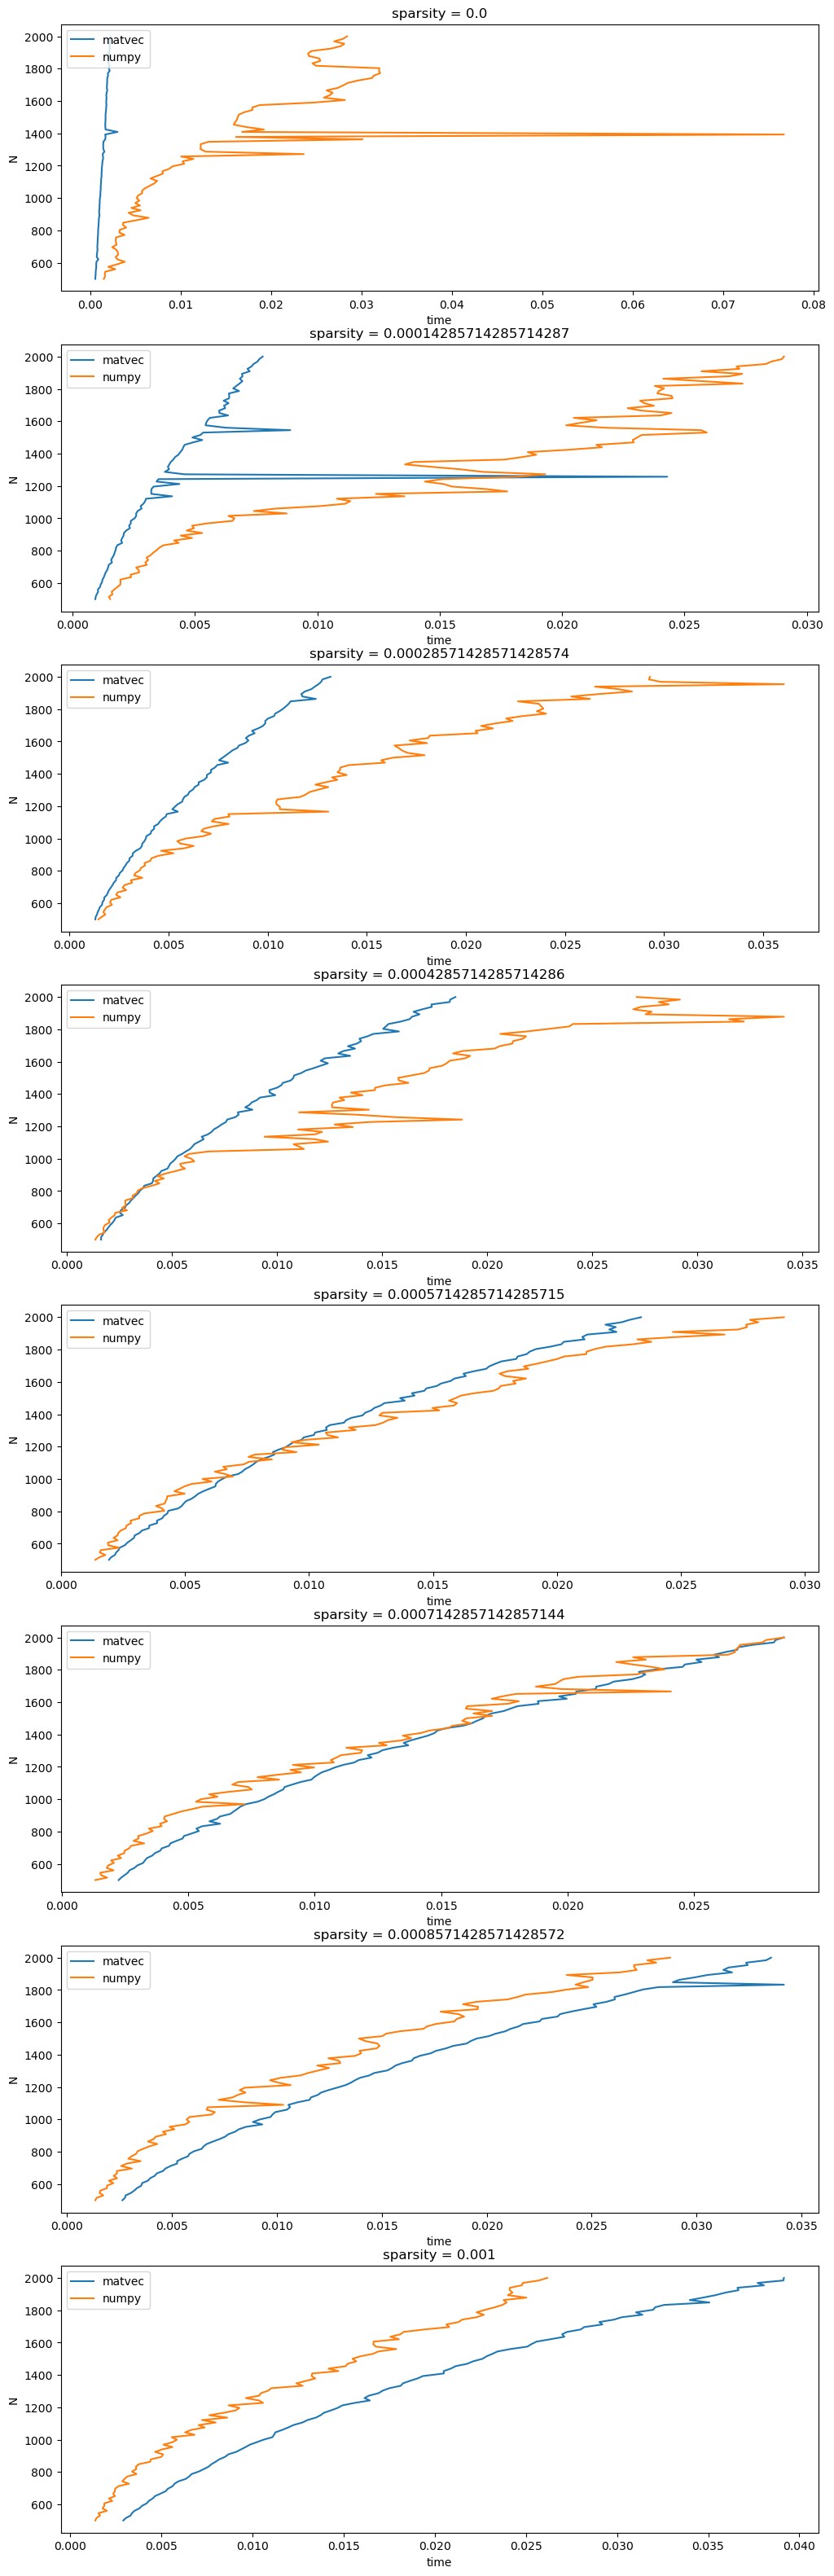

In [60]:


def try_product():
    Sparsities = np.linspace(0, 0.001, 8)
    Ns = np.linspace(500, 2000, 100, dtype=np.int32)

    times0 = np.zeros([Sparsities.size, len(Ns)])
    times1 = np.zeros([Sparsities.size, len(Ns)])
    repeat = 4
    fig = plt.figure(figsize=(12, 40))
    for i, sparsity in enumerate(tqdm(Sparsities)):
        for j, N in enumerate(Ns):
            COO_mat1 = generate_random_coo(N, int(N * N * sparsity))
            nparray_1 = COO_mat1.toarray()
            my_mat1 = CSRMatrix(COO_mat1)
            vector = np.random.random(N)

            t = timeit.Timer(lambda: my_mat1 * vector).timeit(repeat)
            times0[i, j] = np.min(t)
            t = timeit.Timer(lambda: np.matmul(nparray_1, vector)).timeit(repeat)
            times1[i, j] = np.min(t)

        plt.subplot(Sparsities.size, 1, i + 1)
        p0, = plt.plot(times0[i, :], Ns)
        p1, = plt.plot(times1[i, :], Ns)
        plt.title('sparsity = {}'.format(sparsity))
        plt.legend([p0, p1], ['matvec', "numpy"], loc='upper left')
        plt.xlabel('time')
        plt.ylabel('N')
    plt.show()


try_product()

briefly (1-2 sentence) comment on what your plot shows.

use Scipy’s gmres and cg sparse solvers to solve a matrix problem using your CSR matrix.
* Check if the two solutions obtained are the same.

In [ ]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import gmres, cg

N = 20


def generate_mat(N):
    assert N >= 0
    if N == 0: return np.array([1]), np.array([1])

    A = np.zeros([N + 1, N + 1], dtype=np.double)
    for i in range(1, N):
        A[i, i - 1:i + 2] = [-1, 2. - (29 * 29 * np.pi * np.pi / 4 / N / N), -1]
    A[0, 0] = 1
    A[N, N] = 1

    A = CSRMatrix(coo_matrix(A))

    return A, np.random.random(N + 1)


A, b = generate_mat(N)
x0, exitCode0 = gmres(A, b)
x1, exitCode1 = cg(A, b)

print(exitCode0)  # 0 indicates successful convergence
print(A.dot(x0))
print('------------')
print(exitCode1)  # 0 indicates successful convergence
print(A.dot(x1))
print('------------')
print(b)
print('------------')
print(np.allclose(A.dot(x0), b, atol=1e-5))
print(np.allclose(A.dot(x1), b, atol=1e-5))

"Briefly comment (1-2 sentences) on why the solutions are or are not the same.

# Part 2

Implement the Scipy LinearOperator.

In [ ]:
from scipy.sparse.linalg import LinearOperator
import numpy as np


class Custom_Mat(LinearOperator):
    def __init__(self, N, dia_mat: np.ndarray, T_mat: np.ndarray, W_mat: np.ndarray):
        assert np.allclose(T_mat.shape, [N, 2])
        assert np.allclose(W_mat.shape, [2, N])
        self.dtype = np.float64

        self.N = N
        self.dia_mat = dia_mat
        self.TW = np.matmul(T_mat, W_mat)

    @property
    def shape(self):
        return self.N * 2, self.N * 2

    def toarray(self):
        A = np.zeros(self.shape, self.dtype)
        A[:self.N, :self.N] = np.diag(self.dia_mat)
        A[self.N:, self.N:] = self.TW
        return A

    def _matvec(self, vector):
        result = np.zeros(2 * N, self.dtype)
        result[:N] = np.multiply(self.dia_mat, vector[:N])
        result[N:] = np.matmul(self.TW, vector[N:])
        return result

create matrices where the entries on the diagonal of the top-left block and in the matrices T and W are random numbers.

measure the time taken to compute matrix-vector products.
measure the time taken by Numpy to compute matrix-vector products.
Make a plot showing time taken against n.

In [ ]:
from tqdm import tqdm
import timeit
import matplotlib.pyplot as plt

Ns = range(1000, 8000, 100)
repeat = 1
times0 = []
times1 = []
for N in tqdm(Ns):
    T_mat = np.random.random([N, 2])
    W_mat = np.random.random([2, N])
    dia_mat = np.random.random(N)

    custom_mat = Custom_Mat(N, dia_mat, T_mat, W_mat)
    custom_array = custom_mat.toarray()
    b = np.random.random(2 * N)

    t = timeit.Timer(lambda: np.matmul(custom_array, b)).timeit(repeat)
    times0.append(np.min(t))

    t = timeit.Timer(lambda: custom_mat * b).timeit(repeat)
    times1.append(np.min(t))

    # assert np.allclose(np.matmul(custom_array, b), custom_mat * b)

plt.figure(figsize=(16, 9))
p0, = plt.plot(times0, Ns)
p1, = plt.plot(times1, Ns)

plt.legend([p0, p1], ["numpy", 'matvec'], loc='upper left')
plt.xlabel('time')
plt.ylabel('N')
plt.show()



Comment (2-4 sentences) on what your plot shows, and why you think one of these methods is faster than the other (or why they take the same amount of time if this is the case).